In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
def downsample_image(image, reduce_factor):
    for i in range(0,reduce_factor):
        #Check if image is color or grayscale
        if len(image.shape) > 2:
            row,col = image.shape[:2]
        else:
            row,col = image.shape

        image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
    return image

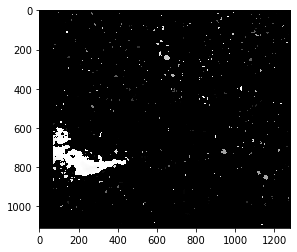

In [4]:
imgR = cv2.imread('right_aloe.jpg', 0)
imgL = cv2.imread('left_aloe.jpg', 0)
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=21)

disparity = stereo.compute(imgR, imgL)
plt.imshow(disparity, 'gray')
plt.show()


Computing the disparity  map...


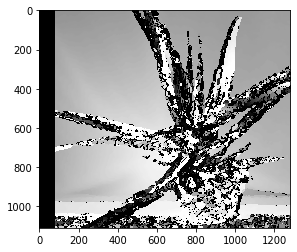

In [10]:
#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 79 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16
#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
 numDisparities = num_disp,
 blockSize = 15,
 uniquenessRatio = 5,
 speckleWindowSize = 5,
 speckleRange = 5,
 disp12MaxDiff = 1,
 P1 = 8*3*win_size**2,#8*3*win_size**2,
 P2 =32*3*win_size**2) #32*3*win_size**2)
#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(imgL, imgR)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

In [7]:
def create_output(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3),colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [ ]:
#!/usr/bin/env python

'''
Simple example of stereo image matching and point cloud generation.
Resulting .ply file cam be easily viewed using MeshLab ( http://meshlab.sourceforge.net/ )
'''

# Python 2/3 compatibility

import numpy as np
import cv2 as cv

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')


print('loading images...')
imgL = cv.pyrDown(cv.imread('left.png'))  # downscale images for faster processing
imgR = cv.pyrDown(cv.imread('right.png'))

# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = -1
num_disp = 16
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 15,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 5,
    speckleRange = 5,
)

print('computing disparity...')
disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

print('generating 3d point cloud...',)
h, w = imgL.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(disp, Q)
colors = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)

cv.imshow('left', imgL)
cv.imshow('disparity', (disp-min_disp)/num_disp)
cv.waitKey()

print('Done')

loading images...
computing disparity...
generating 3d point cloud...
out.ply saved


In [12]:
# #Generate  point cloud. 

# print ("\nGenerating the 3D map...")
# #Get new downsampled width and height 
# h,w = imgL.shape[:2]
# #Load focal length. 
# focal_length = np.load('./camera_params/FocalLength.npy')
# #Perspective transformation matrix
# #This transformation matrix is from the openCV documentation, didn't seem to work for me. 
# Q = np.float32([[1,0,0,-w/2.0],
#     [0,-1,0,h/2.0],
#     [0,0,0,-focal_length],
#     [0,0,1,0]])
# #This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
# #Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
# Q2 = np.float32([[1,0,0,0],
#     [0,-1,0,0],
#     [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
#     [0,0,0,1]])
# #Reproject points into 3D
# points_3D = cv2.reprojectImageTo3D(disparity_map, Q2)

# #Get color points
# imgR =  np.asarray(imgR, dtype=np.uint8)
# print(imgR)

# colors = cv2.cvtColor(imgR, cv2.COLOR_GRAY2RGB)
# #Get rid of points with value 0 (i.e no depth)
# mask_map = disparity_map > disparity_map.min()
# #Mask colors and points. 
# output_points = points_3D[mask_map]
# output_colors = colors[mask_map]
# #Define name for output file
# output_file = 'reconstructed_duck.ply'
# #Generate point cloud 
# print ("\n Creating the output file... \n")
# create_output(output_points, output_colors, output_file)
# print ("File created")


Generating the 3D map...
[[159 140 129 ... 191 203 196]
 [199 174 151 ... 182 202 197]
 [208 194 183 ... 170 203 203]
 ...
 [215 220 222 ... 191 185 185]
 [218 219 220 ... 184 178 178]
 [220 217 216 ... 184 187 187]]

 Creating the output file... 

File created
